<a href="https://colab.research.google.com/github/Suraez/major-project/blob/main/speechRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install sounddevice

In [ ]:
import torch
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io import wavfile
from IPython.display import Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [ ]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:748: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Model Architecture**


In [ ]:
print(model)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

wav2vec2.masked_spec_embed 	 torch.Size([768])
wav2vec2.feature_extractor.conv_layers.0.conv.weight 	 torch.Size([512, 1, 10])
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight 	 torch.Size([512])
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias 	 torch.Size([512])
wav2vec2.feature_extractor.conv_layers.1.conv.weight 	 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.2.conv.weight 	 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.3.conv.weight 	 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.4.conv.weight 	 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.5.conv.weight 	 torch.Size([512, 512, 2])
wav2vec2.feature_extractor.conv_layers.6.conv.weight 	 torch.Size([512, 512, 2])
wav2vec2.feature_projection.layer_norm.weight 	 torch.Size([512])
wav2vec2.feature_projection.layer_norm.bias 	 torch.Size([512])
wav2vec2.feature_projection.projection.weight 	 torch.Size([768, 512])
wav2vec2.feature_projection.pr

**Saving Model And Loading Model**

In [ ]:
!pip install datasets
!pip install jiwer

     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 61.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.8 MB/s 
     |████████████████████████████████| 136 kB 38.9 MB/s 
     |████████████████████████████████| 127 kB 59.6 MB/s 
     |████████████████████████████████| 144 kB 53.2 MB/s 
     |████████████████████████████████| 271 kB 67.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149873 sha256=784c4b3569e65ce05c32a40a5fd204c1de014d07eeda316412ff4c254272cbea
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
from jiwer import wer


librispeech_eval = load_dataset("librispeech_asr", "clean", split="test")

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cuda")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def map_to_pred(batch):
    input_values = processor(batch["audio"]["array"], return_tensors="pt", padding="longest").input_values
    with torch.no_grad():
        logits = model(input_values.to("cuda")).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch

result = librispeech_eval.map(map_to_pred, batched=True, batch_size=1, remove_columns=["audio"])

print("WER:", wer(result["text"], result["transcription"]))


Generating train.100 split:   0%|          | 0/28539 [00:00<?, ? examples/s]

Generating train.360 split:   0%|          | 0/104014 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2703 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2620 [00:00<?, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/1f4602f6b5fed8d3ab3e3382783173f2e12d9877e98775e34d7780881175096c. Subsequent calls will reuse this data.


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def word_error_rate(obtained_output, actual_output):
  actualWordLi = actual_output.split(' ')
  actualWordTup = tuple(actualWordLi) 
  obtWordLi = obtained_output.split(' ')
  obtWordTup = tuple(obtWordLi)
  myzip = zip(actualWordTup, obtWordTup)
  error = 0
  for word1, word2 in myzip:
    if word1.lower() != word2.lower():
      error += 1
  print((error / len(actualWordLi)) * 100)

In [ ]:
def word_error_rate2(ref, hyp ,debug=False):
    r = ref.split()
    h = hyp.split()
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]

    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3

    DEL_PENALTY=1 
    INS_PENALTY=1 
    SUB_PENALTY=1 
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL

    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS

    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY 
                insertionCost    = costs[i][j-1] + INS_PENALTY   
                deletionCost     = costs[i-1][j] + DEL_PENALTY   

                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("Ncor " + str(numCor))
        print("Nsub " + str(numSub))
        print("Ndel " + str(numDel))
        print("Nins " + str(numIns))
    return (numSub + numDel + numIns) / (float) (len(r))
    wer_result = round( (numSub + numDel + numIns) / (float) (len(r)), 3)
    return {'WER':wer_result, 'Cor':numCor, 'Sub':numSub, 'Ins':numIns, 'Del':numDel}

In [ ]:
def char_error_rate(ref, hyp):
  if len(ref) < len(hyp):
    min_length_word = ref[:]
    print('true')
  else:
    min_length_word = hyp[:]
  count = 0
  for i in range(len(min_length_word)):
    if ref[i] != hyp[i]:
      count +=1

  return 'Character Error Rate: {}'.format((count/len(ref)))
    

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [ ]:
def char_error_rate2(ref, hyp):
  cer_score = cer_metric.compute(predictions=[hyp], references=[ref])
  return 'Character Error Rate: {}'.format(cer_score)

In [ ]:
def print_spectogram(filename):
  y, sr = librosa.load(filename, sr=16000)
  #pre-emphasis
  alpha = 0.97
  yemp = np.append(y[0], y[1:] - alpha * y[:-1])
  #framing
  fig, ax = plt.subplots(figsize=(14, 5))
  time = np.linspace(0, len(y)/sr, num=len(y))
  ax.set_title("Amplitude vs Time")
  ax.set_ylabel("Amplitude")
  ax.set_xlabel("Time (seconds)")
  ax.plot(time, yemp)
  frame_size = 0.02
  frame_stride = 0.01 

  frame_length, frame_step = int(round(frame_size * sr)), int(round(frame_stride * sr))  
  signal_length = len(yemp)

  num_frames = int(np.ceil(float(signal_length - frame_length) / frame_step))  

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(yemp, z) 

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]

  #windowing
  frames = frames * np.hamming(frame_length)
  NFFT = 512
  magnitude = np.absolute(np.fft.rfft(frames, NFFT))
  pow_frames = magnitude**2/NFFT
  # spectogram
  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  ax = fig.add_subplot(111) 
  librosa.display.specshow(pow_frames,ax=ax, x_axis='time', y_axis='hz')
  nfilt = 40

  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2) 
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  temp_bin = np.floor((NFFT + 1) * hz_points / sr)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

  for m in range(1, nfilt + 1):
      f_m_minus = int(temp_bin[m - 1])   
      f_m = int(temp_bin[m])             
      f_m_plus = int(temp_bin[m + 1])    

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - temp_bin[m - 1]) / (temp_bin[m] - temp_bin[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (temp_bin[m + 1] - k) / (temp_bin[m + 1] - temp_bin[m])

  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  filter_banks = 20 * np.log10(filter_banks)
  plt.figure(figsize=(8, 4))
  librosa.display.specshow(filter_banks, x_axis='time')

In [ ]:
def find_all_metrics(ref, hyp, filename):
  print("References(Actual Text): ", ref)
  print("Hypothesis(Output Text): ", hyp)
  print('Word Error Rate:', word_error_rate2(ref, hyp))
  print_spectogram(filename)
  print(char_error_rate2(ref, hyp))

In [ ]:
file_name = '/content/test.wav'
Audio(file_name)

In [ ]:
data = wavfile.read(file_name)
framerate = data[0]
sounddata = data[1]
time = np.arange(0,len(sounddata))/framerate
input_audio, _ = librosa.load(file_name, sr=16000)
input_values = tokenizer(input_audio, return_tensors="pt").input_values
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)[0]
transcription

'THIS IS DUST AT DISTI'

References(Actual Text):  this is just a testing
Hypothesis(Output Text):  THIS IS DUST AT DISTI
Word Error Rate: 1.0
Character Error Rate: 0.8636363636363636


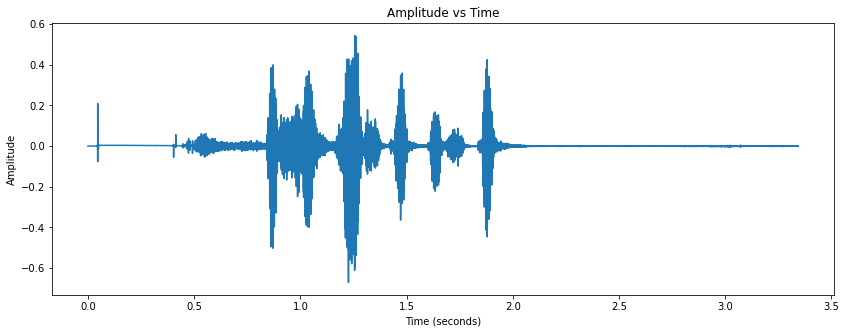

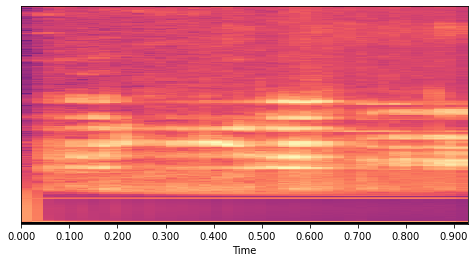

In [ ]:
find_all_metrics('this is just a testing', transcription, file_name)